In [1]:
import pandas as pd
import numpy as np
from DynamicFactor import DynamicFactorModel
from ForecastingwithDFM import ForecastingWithDFM
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pykalman import KalmanFilter
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
# Lecture du fichier *.txt
data = pd.read_csv('fredmq.txt', sep=',').set_index(keys='Date')
# Récupération des types de transformations dans un dictionnaire
transformations = dict(data.loc['Transform']) 
# Abandon de la ligne des transformations
data.drop(labels='Transform', inplace=True)
# Ajustement de l'indice du DataFrame au format datetime
data.index = pd.to_datetime(arg=data.index)
# Abandon des colonnes ayant un nombre de NaN's >= 30
data.dropna(thresh=len(data) - 30, axis=1, inplace=True)
# Abandon des NaN's restants
data.dropna(axis=0, inplace=True)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1983-01-01,6279.297,5458.2,35.639,528823.390,94918.74337,47.7491,54.0227,52.9980,65.5034,41.2399,...,52.789,35.357,9.20,11.30,8.52,70.4,44428.00,77668.34,339.7161,26.1745
1983-02-01,6283.890,5458.5,35.630,526595.607,95181.13607,47.4548,53.5509,52.4299,64.6658,41.1003,...,52.627,35.497,9.25,11.39,8.59,74.6,44684.00,77656.47,345.6982,22.4658
1983-03-01,6314.258,5480.2,36.005,535427.434,97716.90740,47.8516,53.9567,52.7186,64.9369,41.6905,...,52.690,35.540,9.24,11.38,8.59,80.8,46149.00,79276.76,354.4036,19.5048
1983-04-01,6319.274,5489.2,36.226,535378.168,97986.55997,48.4511,54.6417,53.3881,66.2526,42.6225,...,53.102,35.668,9.25,11.37,8.61,89.1,46982.00,79870.50,363.3154,18.6576
1983-05-01,6351.636,5514.5,36.441,543698.110,99628.32930,48.7542,54.9550,53.6858,66.4798,43.4404,...,53.443,35.729,9.26,11.31,8.64,93.3,47703.00,80624.04,371.7129,18.0774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,18684.453,14732.0,103.540,1423157.000,540423.00000,95.8881,95.9659,96.6222,100.6005,106.4999,...,101.271,107.261,25.50,29.39,22.87,74.1,344023.25,726723.85,4378.7008,22.8791
2020-09-01,18796.082,14899.2,104.986,1431727.000,551131.00000,95.8444,95.3901,95.5632,99.2739,105.1224,...,101.138,107.596,25.43,29.04,22.98,80.4,347627.43,730734.42,4458.7684,27.5874
2020-10-01,18795.426,15128.9,105.251,1441300.000,549271.00000,96.4292,95.9653,95.7471,99.3411,105.2266,...,100.974,107.743,25.54,29.33,22.99,81.8,348262.68,730398.69,4525.3995,29.4362


In [3]:
# Création du DataFrame stockant les séries transformées
transformed_data = pd.DataFrame()
# Transformation des séries selon les codes fournis par McCracken et Ng
for col in data.columns:
    # Récupération du code de transformation
    code = transformations[col]
    # Récupération de la série individuelle
    subset = data[col]
    # Application des transformées selon le code correspondant
    if code == 1:
        # Aucune transformation à appliquer
        temp = subset
    elif code == 2:
        # Différence première
        temp = subset.diff(periods=1)
    elif code == 3:
        # Différence seconde 
        temp = subset.diff(periods=1).diff(periods=1)
    elif code == 4:
        # Transformée en log
        temp = np.log(subset)
    elif code == 5:
        # Différence première du log
        temp = np.log(subset).diff(periods=1)
    elif code == 6:
        # Différence seconde du log 
        temp = np.log(subset).diff(periods=1).diff(periods=1)
    elif code == 7:
        # Différence première de la variation relative
        temp = subset.pct_change().diff(periods=1)
    # Aggrégation des séries transformées
    transformed_data = pd.concat([transformed_data, temp], axis=1)
# Abandon des NaN's causées par les différences premières et secondes
transformed_data.dropna(axis=0, inplace=True)

In [4]:
# Calcul de la médiane des séries
medians = transformed_data.median(axis=0)
# DataFrame contenant les médianes des séries en chaque point
mdf =  transformed_data * 0 + medians
# Calcul de la distance entre les observations et les médianes
z = abs(transformed_data - mdf)
# Calcul de la gamme interquartile des séries
irq = transformed_data.quantile(q=.75) - transformed_data.quantile(q=.25)
# DataFrame contenant les gammes interquartiles des séries en chaque point
irqdf = transformed_data * 0 + irq
# Détermination des outliers (x est un outlier si abs(x - mediane) > 10 * gamme interquartile)
outliers = z > 10 * irqdf
# Abandon des observations considérées comme outliers
mapping = transformed_data[outliers == False].dropna(axis=0)

In [5]:
# Sélection de la période d'estimation
estimation_sample = mapping.loc[(mapping.index >= pd.to_datetime('1983-01-01')) & (mapping.index <= pd.to_datetime('2016-12-01'))]
# Sélection de la période de prévision
forecast_sample = mapping.loc[mapping.index >= pd.to_datetime('2017-01-01')]

In [24]:
estimation_sample

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1983-03-01,0.004821,0.003968,0.010470,0.016632,0.026293,0.008327,0.007549,0.005491,0.004184,0.014258,...,0.004270,-0.002741,-0.006502,-8.811401e-03,-0.008182,6.2,0.026514,0.020803,0.007414,19.5048
1983-04-01,0.000794,0.001641,0.006119,-0.000092,0.002756,0.012450,0.012615,0.012620,0.020059,0.022109,...,0.006593,0.002384,0.002163,-7.721748e-07,0.002326,8.3,-0.014371,-0.013189,-0.000035,18.6576
1983-05-01,0.005108,0.004598,0.005917,0.015421,0.016616,0.006236,0.005717,0.005561,0.003423,0.019008,...,-0.001388,-0.001886,-0.000001,-4.411897e-03,0.001153,4.2,-0.002660,0.001929,-0.001984,18.0774
1983-06-01,0.001363,0.002789,0.009586,0.025368,0.022806,0.006041,0.004946,0.003759,0.003506,0.017475,...,-0.004569,0.003400,0.001077,6.174800e-03,-0.001166,-1.1,0.012433,0.010404,0.000451,18.9343
1983-07-01,0.002821,0.005860,0.006772,-0.000532,0.005844,0.014727,0.013717,0.013359,0.013096,0.023280,...,0.001580,0.002326,0.002144,-8.837826e-04,0.003445,0.6,-0.011080,-0.009033,-0.020723,23.1521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,0.001110,0.000772,0.001075,0.007602,0.001050,-0.000816,-0.000080,0.001388,0.002168,-0.003199,...,0.006930,-0.000496,0.000440,-5.880916e-07,0.001460,-0.2,0.018500,0.007896,-0.004765,12.2931
2016-09-01,0.002354,0.003023,0.002668,0.001418,0.006578,-0.000971,-0.000904,-0.002107,-0.002029,0.003749,...,0.003714,-0.000636,0.000879,1.911825e-03,-0.001950,1.4,-0.006567,-0.003611,0.003978,14.1336
2016-10-01,0.001716,0.001269,-0.000459,0.001230,0.002083,0.000736,-0.001517,-0.001280,-0.005061,0.006258,...,-0.000274,0.000506,-0.000444,-7.154680e-06,0.000486,-4.0,-0.014159,-0.006369,-0.002721,14.5743
2016-11-01,0.002658,0.003612,0.001684,0.000387,-0.000283,-0.003927,-0.004543,-0.006522,-0.010497,-0.015893,...,-0.005417,-0.000065,-0.000442,-2.290223e-03,-0.000486,6.6,0.000083,0.001102,-0.008778,14.9940


In [6]:
# Standardisation des données d'estimation en échantillon
estimation_sample_std = (estimation_sample - estimation_sample.mean(axis=0)) / estimation_sample.std(axis=0)
# Standardisation des données d'estimation hors échantillon
forecast_sample_std = (forecast_sample - forecast_sample.mean(axis=0)) / forecast_sample.std(axis=0)


### Méthode ML-NO (Maximum Likelihood sans Normalité)

La méthode ML-NO utilise un filtre de Kalman pour estimer les états basés sur un modèle autorégressif vectoriel des facteurs communs, puis maximise la fonction de log-vraisemblance pour optimiser les paramètres du modèle sous certaines restrictions d'identification. Cette méthode est directement appliquée lorsque vous ne supposez pas la normalité des perturbations.

Voici une implémentation possible de la fonction `fit_ml_no` :

1. **Initialiser le Filtre de Kalman** : Configurez le filtre de Kalman avec les paramètres initiaux du modèle. Cela comprend les matrices de transition, de covariance, et les matrices d'observation qui correspondent aux chargements des facteurs et aux variances idiosyncratiques initiales.

2. **Estimation des états et des covariances** : Utilisez le filtre de Kalman pour estimer les états (les facteurs communs à chaque temps) et leurs covariances. Ces estimations sont basées sur les observations à chaque pas de temps.

3. **Calcul de la log-vraisemblance** : Après l'estimation des états, calculez la log-vraisemblance de l'ensemble des observations. Cette fonction de vraisemblance est ensuite optimisée (par exemple, en utilisant des algorithmes d'optimisation comme Newton-Raphson) pour trouver les paramètres optimaux du modèle en respectant les restrictions d'identification imposées (telles que des contraintes sur les matrices de covariance).

### Méthode ML-EM (Maximum Likelihood via Expectation-Maximization)

La méthode ML-EM est une approche itérative qui alterne entre l'estimation des états des facteurs (Expectation) et l'optimisation des paramètres du modèle (Maximization) pour maximiser la log-vraisemblance globale du modèle.

Voici une implémentation possible de la fonction `fit_ml_em` :

1. **Initialisation** : Commencez par des valeurs initiales des paramètres basées sur des estimations préliminaires (par exemple, des estimations obtenues par analyse en composantes principales ou un autre estimateur simple).

2. **Étape d'Expectation** : À cette étape, utilisez le Filtre de Kalman pour estimer les états des facteurs communs en utilisant les paramètres actuels du modèle. Cette étape produit des estimations des facteurs et de leurs erreurs de prédiction.

3. **Étape de Maximization** : Avec les estimations obtenues lors de l'étape d'Expectation, optimisez les paramètres du modèle (matrices de transition, matrices de covariance, chargements des facteurs) pour maximiser la log-vraisemblance calculée à partir des résidus de l'étape d'Expectation.

4. **Itération** : Répétez les étapes d'Expectation et de Maximization jusqu'à convergence des paramètres, ce qui indique que le modèle est bien ajusté aux données.

Ces deux méthodes, surtout l'EM, nécessitent souvent des bibliothèques spécialisées pour la manipulation de séries temporelles et l'optimisation numérique, comme `statsmodels` ou `scipy` en Python. Ces explications sont très générales et pourraient nécessiter des ajustements spécifiques pour s'adapter précisément à vos données et à votre contexte d'analyse.

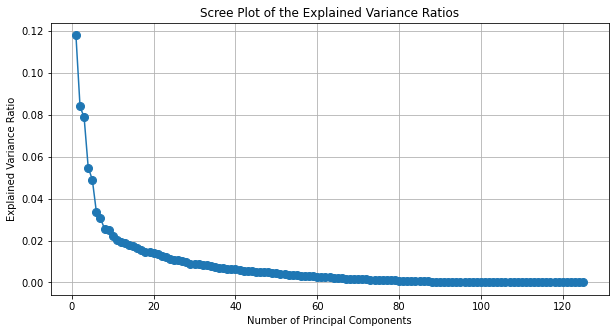

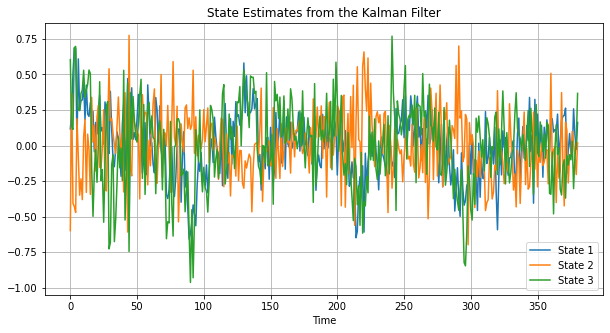

In [7]:
# PCA analysis
pca = PCA()
pca.fit(estimation_sample_std)
explained_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

# Plotting PCA results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, 'o-', markersize=8)
plt.title('Scree Plot of the Explained Variance Ratios')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Using PyKalman for the Kalman Filter
# Set up some dummy values for demonstration
n_timesteps = data.shape[0]  # Number of time steps
n_dim_state = 3  # Dimensionality of the state
n_dim_obs = data.shape[1]  # Dimensionality of the observations

# Initialize the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.eye(n_dim_state),
    observation_matrices=np.random.rand(n_dim_obs, n_dim_state),
    transition_covariance=0.01 * np.eye(n_dim_state),
    observation_covariance=0.01 * np.eye(n_dim_obs),
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=0.1 * np.eye(n_dim_state)
)

# Use the Kalman Filter to estimate states
state_means, state_covariances = kf.smooth(estimation_sample_std)

# Example of plotting state estimates
plt.figure(figsize=(10, 5))
for i in range(n_dim_state):
    plt.plot(state_means[:, i], label=f'State {i+1}')
plt.title('State Estimates from the Kalman Filter')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Conversion du DataFrame en numpy array pour utilisation dans les modèles statistiques
data_matrix = estimation_sample_std.values  # Convertit le DataFrame en numpy array

In [44]:
estimation_sample['INDPRO']

1983-03-01    0.008327
1983-04-01    0.012450
1983-05-01    0.006236
1983-06-01    0.006041
1983-07-01    0.014727
                ...   
2016-08-01   -0.000816
2016-09-01   -0.000971
2016-10-01    0.000736
2016-11-01   -0.003927
2016-12-01    0.006953
Name: INDPRO, Length: 381, dtype: float64

C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


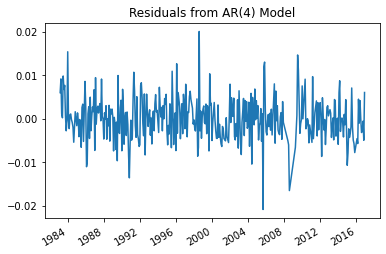

                               SARIMAX Results                                
Dep. Variable:                 INDPRO   No. Observations:                  381
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1482.527
Date:                Tue, 14 May 2024   AIC                          -2953.054
Time:                        14:33:01   BIC                          -2929.397
Sample:                             0   HQIC                         -2943.668
                                - 381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000      4.688      0.000       0.001       0.003
ar.L1          0.0860      0.043      2.019      0.043       0.003       0.169
ar.L2          0.2341      0.047      4.982      0.0

In [56]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Construction et ajustement du modèle AR(4)
model = ARIMA(estimation_sample['INDPRO'], order=(4,0,0))
results = model.fit()

# Diagnostiques des résidus
residuals = results.resid
residuals.plot(title="Residuals from AR(4) Model")
plt.show()
# Affichage du résumé du modèle
print(results.summary())
# Calcul de R^2 ajusté
n = len(estimation_sample['INDPRO'])  # Nombre d'observations
p = 4  # Nombre de prédicteurs (ordre de l'AR)
ss_res = residuals.pow(2).sum()
ss_tot = ((estimation_sample['INDPRO'] - estimation_sample['INDPRO'].mean())**2).sum()
r_squared = 1 - (ss_res / ss_tot)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print(f'R-squared: {r_squared}')
print(f'Adjusted R-squared: {adjusted_r_squared}')


['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4']
1983-11-01    0.004412
1983-12-01    0.005045
1984-01-01    0.019598
1984-02-01    0.004659
1984-03-01    0.004671
                ...   
2016-08-01   -0.000816
2016-09-01   -0.000971
2016-10-01    0.000736
2016-11-01   -0.003927
2016-12-01    0.006953
Name: INDPRO, Length: 373, dtype: float64


C:\Users\jeanb\AppData\Local\Temp/ipykernel_16060/2304055727.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estimation_sample[f'Lag_{i}'] = estimation_sample['INDPRO'].shift(i)
C:\Users\jeanb\AppData\Local\Temp/ipykernel_16060/2304055727.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_clean['Prediction'] = lm.predict(X)
C:\Users\jeanb\AppData\Local\Temp/ipykernel_16060/2304055727.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

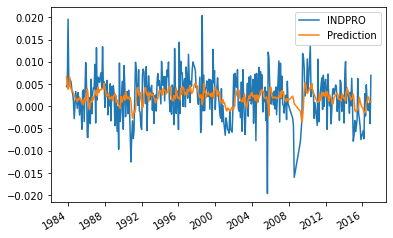

Intercept: 0.0011958153475492425
Coefficients: [0.07013151 0.22302775 0.09446457 0.03922397]
Mean Squared Error: 2.4052386926200254e-05
R²: 0.08764684618206431
Adjusted R²: 0.0777299640753476


In [79]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Configuration initiale
q = 4  # Nombre de délais pour AR
s = 4  # Nombre de retards pour chaque facteur PCA
r = 0  # Nombre initial de facteurs

# Ajout des délais de la série temporelle
for i in range(1, q + 1):
    estimation_sample[f'Lag_{i}'] = estimation_sample['INDPRO'].shift(i)

# Vérifiez combien de lignes restent après suppression des NaNs
non_nan_data = estimation_sample[[f'Lag_{i}' for i in range(1, q+1)]].dropna()
r = min(r, non_nan_data.shape[1])  # Ajustement de r pour qu'il ne dépasse pas le nombre de colonnes

# Application de PCA
pca = PCA(n_components=r)
pca_data = pca.fit_transform(non_nan_data)

# Intégration des facteurs PCA dans les données
for i in range(r):
    padded_data = np.pad(pca_data[:, i], (q, 0), 'constant', constant_values=(np.nan,))
    estimation_sample[f'PC_{i+1}'] = padded_data
    for j in range(1, s + 1):
        estimation_sample[f'PC_{i+1}_Lag_{j}'] = estimation_sample[f'PC_{i+1}'].shift(j)

# Nettoyage des données pour retirer les NaN
data_clean = estimation_sample.dropna()

# Construction du modèle DFM
features = [f'Lag_{i}' for i in range(1, q+1)] + [f'PC_{i+1}_Lag_{j}' for i in range(r) for j in range(1, s+1)]
print(features)
X = data_clean[features]
y = data_clean['INDPRO']
print(y)
# Modèle de régression linéaire
lm = LinearRegression()
lm.fit(X, y)

# Prédiction et visualisation
data_clean['Prediction'] = lm.predict(X)
data_clean[['INDPRO', 'Prediction']].plot()
plt.show()

# Affichage du résumé du modèle et calcul des métriques
print("Intercept:", lm.intercept_)
print("Coefficients:", lm.coef_)
mse = mean_squared_error(data_clean['INDPRO'], data_clean['Prediction'])
r2 = r2_score(data_clean['INDPRO'], data_clean['Prediction'])
adjusted_r2 = 1 - (1 - r2) * (data_clean.shape[0] - 1) / (data_clean.shape[0] - len(features) - 1)

print(f"Mean Squared Error: {mse}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adjusted_r2}")


In [80]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
from scipy.stats import norm
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.optimize import minimize
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter


class FactorAnalysisModel:
    def __init__(self, data, num_factors, lags):
        # Initializations
        #self.loadings = None
        self.factor_scores = None
        self.residuals = None
        self.phi11=None
        self.phi21=None
        self.phi31=None
        self.log_likelihood = 0
        self.data = data
        self.r = num_factors  # Nombre de facteurs
        self.p = lags          # Nombre de retards dans le modèle VAR
        self.T = data.shape[0]  # Nombre d'observations (temps)
        self.N = data.shape[1]  # Nombre de variables observées
        # Initialisation aléatoire des chargements
        self.loadings = np.random.randn(self.N, self.r)
        # Initialisation aléatoire des matrices de transition des facteurs
        self.transition_matrices = np.random.randn(self.r, self.r*self.p)#* self.p)
        # Initialisation de la matrice de covariance des observations
        self.obs_cov = np.cov(self.data.values.T)#np.eye(self.N)
        print(self.obs_cov.shape)
    def fit_ts_ls(self):
        # Perform Two-Stage Least Squares Estimation
        # # Étape 1: PCA pour obtenir les scores des facteurs
        pca = PCA(n_components=self.r)
        self.factor_scores = pca.fit_transform(self.data)
        self.loadings = pca.components_.T
        # Étape 2: Estimer un modèle VAR sur les scores des facteurs
        model = VAR(self.factor_scores)
        fitted_model = model.fit(maxlags=self.p,ic='aic')
        print(fitted_model.summary())
        self.transition_matrices = fitted_model.params
        # Extrait et stocke spécifiquement phi11, phi21, phi31
        # Nous supposons ici que `self.transition_matrices` est structurée avec des lignes pour chaque lag et des colonnes pour chaque facteur
        if self.r >= 3 and self.p >= 1:  # Assurez-vous qu'il y a suffisamment de facteurs et de lags
            self.phi11 = self.transition_matrices[1, 0]  # phi11
            self.phi21 = self.transition_matrices[1, 1]  # phi21 si r >= 2
            self.phi31 = self.transition_matrices[2, 2]  # phi31 si r >= 3
            print(f"phi11: {self.phi11}, phi21: {self.phi21}, phi31: {self.phi31}")
        elif self.r==1:
            phis = [fitted_model.params[i, 0] for i in range(self.p)]
            print("Coefficients AR(p) sans constante:", phis)
        else:
            print("Not enough factors or lags to retrieve all requested phi values.")

    def fit_ml_nob(self):
        """
        Fit the model using Maximum Likelihood without Normality assumptions
        using Kalman Filter and optimization for parameter estimation.
        """
        def log_likelihood(params):
            self.loadings = params[:self.N * self.r].reshape(self.N, self.r)
            transition_matrices = params[self.N * self.r:self.N * self.r + self.r ** 2].reshape(self.r, self.r)

            kf = KalmanFilter(self.N, self.r)
            kf.obs_cov = self.obs_cov
            kf.state_cov = np.eye(self.r)
            kf.design = self.loadings
            kf.transition = transition_matrices

            kf.initialize_approximate_diffuse()
            kf.loglikelihood_burn = 1
            filtered = kf.filter(self.data.values)
            loglike = 0
            for t in range(self.T):
                F_t = filtered.forecasts_error_cov[t]
                f_t = filtered.forecasts_error[:, t]
                _, logdet = slogdet(F_t)
                loglike += -0.5 * (np.log(2 * np.pi) + logdet + f_t.T @ inv(F_t) @ f_t)
            return -loglike  # Negative log-likelihood for minimization
        initial_params = np.hstack([self.loadings.ravel(), self.transition_matrices.ravel()])
        result = minimize(log_likelihood, initial_params, method='L-BFGS-B')
        optimized_params = result.x
        self.loadings = optimized_params[:self.N * self.r].reshape(self.N, self.r)
        self.transition_matrices = optimized_params[self.N * self.r:self.N * self.r + self.r ** 2].reshape(self.r, self.r)
    def fit_ml_no(self):
        """
        Fit the model using Maximum Likelihood without Normality assumptions
        using Kalman Filter and optimization for parameter estimation.
        """
        def log_likelihood(params):
            # Redéfinir les matrices de charge et de transition à partir des paramètres
            self.loadings = params[:self.N * self.r].reshape(self.N, self.r)
            transition_matrices = params[self.N * self.r:self.N * self.r + self.r ** 2].reshape(self.r, self.r)
    
            kf = KalmanFilter(self.N, self.r)
            kf.obs_cov = self.obs_cov
            kf.state_cov = np.eye(self.r)  # Supposons que la covariance de l'état est l'identité pour simplifier
            kf.design = self.loadings
            kf.transition = transition_matrices
    
            kf.initialize_approximate_diffuse()
            kf.loglikelihood_burn = 1
    
            kf.bind(self.data.values)  # S'assurer que les données sont correctement liées
            filtered = kf.filter()
            loglike = 0
            for t in range(self.T):
                F_t = filtered.forecasts_error_cov[t]
                f_t = filtered.forecasts_error[:, t]
                _, logdet = np.linalg.slogdet(F_t)
                loglike += -0.5 * (np.log(2 * np.pi) + logdet + np.dot(f_t.T, np.linalg.inv(F_t), f_t))
    
            return -loglike  # Negative log-likelihood for minimization
    
        initial_params = np.hstack([self.loadings.ravel(), self.transition_matrices.ravel()])
        result = minimize(log_likelihood, initial_params, method='L-BFGS-B')
        optimized_params = result.x
        self.loadings = optimized_params[:self.N * self.r].reshape(self.N, self.r)
        self.transition_matrices = optimized_params[self.N * self.r:self.N * self.r + self.r ** 2].reshape(self.r, self.r)


    def fit_ml_em(self):
        """
        Fit the model using EM algorithm, iteratively updating parameters.
        """
        for _ in range(10):  # Number of EM iterations
            # E-step: Estimate states using Kalman Filter
            kf = KalmanFilter(self.N, self.r)
            kf.obs_cov = self.obs_cov
            kf.state_cov = np.eye(self.r)
            kf.design = self.loadings
            kf.transition = self.transition_matrices
            kf.initialize_approximate_diffuse()
            kf.loglikelihood_burn = 1

            result = kf.filter(self.data.values)
            filtered_state = result.filtered_state
            filtered_state_cov = result.filtered_state_cov

            # M-step: Update parameters
            self.loadings = np.dot(np.linalg.pinv(filtered_state), self.data).T
            for t in range(1, self.T):
                self.transition_matrices += filtered_state[:, t] @ inv(filtered_state_cov[:, :, t-1]) @ filtered_state[:, t-1].T
            self.transition_matrices /= (self.T - 1)

            # Calculate log-likelihood
            self.log_likelihood = 0
            for t in range(self.T):
                F_t = result.forecasts_error_cov[t]
                f_t = result.forecasts_error[:, t]
                _, logdet = slogdet(F_t)
                self.log_likelihood += -0.5 * (np.log(2 * np.pi) + logdet + f_t.T @ inv(F_t) @ f_t)

    def calculate_metrics(self):
        # Calcul des métriques
        loadings_sq_sum = np.sum(self.loadings ** 2)
        residuals = self.data - np.dot(self.factor_scores, self.loadings.T)
        idiosyncratic_var_sum = np.sum(np.var(residuals, axis=0))

        mse = np.mean(residuals**2)
        # Calcul du MSE pour F1t
        if self.r >= 1:  # Vérifie que le premier facteur existe
            f1_scores = self.factor_scores[:, 0]  # Scores du premier facteur
            # Prédictions basées sur les modèles AR(p) si applicable
            f1_predicted = np.zeros_like(f1_scores)
            for i in range(self.p, self.T):  # Commence après p périodes initiales
                for p in range(1, self.p+1):
                    f1_predicted[i] += self.transition_matrices[0, p-1] * f1_scores[i-p]
            
            mse_f1t = np.mean((f1_scores[self.p:] - f1_predicted[self.p:])**2)
        else:
            mse_f1t = None

        return {
            "Sum of Squares of Factor Loadings": loadings_sq_sum,
            "Sum of Idiosyncratic Variances": idiosyncratic_var_sum,
            "Transition Matrices (Φ coefficients)": self.transition_matrices,
            "MSE": mse,
            "MSE F1t":mse_f1t            
        }
        
model = FactorAnalysisModel(estimation_sample_std, num_factors=7, lags=3)
model.fit_ts_ls()
metrics = model.calculate_metrics()
print(metrics)

(125, 125)
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, May, 2024
Time:                     17:29:46
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    8.92813
Nobs:                     378.000    HQIC:                   7.96127
Log likelihood:          -4984.94    FPE:                    1519.21
AIC:                      7.32503    Det(Omega_mle):         1022.45
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.009807         0.131833            0.074           0.941
L1.y1         0.365039         0.077204            4.728           0.000
L1.y2         0.226530         0.184986            1.225           0.221
L1.y3      

In [81]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# Load your data
# Assuming data_statio is a DataFrame with the necessary columns

# Example: data_statio = pd.read_csv('path_to_your_data.csv')

# Define the number of lags for y and the number of factors
num_lags = 3
num_factors = 3

# Assuming the target column is named 'y'
y = estimation_sample['INDPRO']

# Generate lags for the target variable
for lag in range(1, num_lags + 1):
    estimation_sample[f'y_lag_{lag}'] = y.shift(lag)

# Standardize predictors excluding lags and target
predictors = estimation_sample.drop(columns=['INDPRO'] + [f'y_lag_{i}' for i in range(1, num_lags + 1)])
X_standardized = (predictors - predictors.mean()) / predictors.std()

# PCA for dimensionality reduction
pca = PCA(n_components=num_factors)
factors = pca.fit_transform(X_standardized)

# Add factors to the DataFrame
for i in range(num_factors):
    estimation_sample[f'factor_{i+1}'] = np.hstack([np.zeros(i + 1), factors[:, i][:-i-1]])

# Create the regression model data, omitting the initial rows with NaN due to lags
reg_data = estimation_sample.dropna()
X = reg_data[[f'y_lag_{i}' for i in range(1, num_lags + 1)] + [f'factor_{j+1}' for j in range(num_factors)]]
y = reg_data['INDPRO']

# Add constant for OLS
X = add_constant(X)

# Fit the OLS model
model = OLS(y, X)
results = model.fit()

print(results.summary())

# Forecasting using the model
# Assume you want to forecast the next value and the required lags and factors are available
# in the last row of the dataset
next_X = add_constant(reg_data.iloc[-1][[f'y_lag_{i}' for i in range(1, num_lags + 1)] + [f'factor_{j+1}' for j in range(num_factors)]].to_frame().T)
forecast_y = model.predict(next_X)
print(f"Forecasted value for the next period: {forecast_y.iloc[0]}")


C:\Users\jeanb\AppData\Local\Temp/ipykernel_16060/3863352057.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estimation_sample[f'y_lag_{lag}'] = y.shift(lag)


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values